# Utilities

In [90]:
data_dir = '../data/'
model_dir = '../models/'
results_dir = '../results/'

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm

def make_corr_plot(actual, predicted):

    m = 1
    b = 0
    correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
    x = np.arange(actual.min(), actual.max(), step=0.1)

    fig = plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, s=30, alpha=0.2)
    plt.plot(x, m*x + b, color='red')
    plt.xlabel('Truth Number of Primary Ionizations')
    plt.ylabel('Predicted Number of Primary Ionizations')
    plt.text(0.05,0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", fontsize=12, color='black', 
             transform=plt.gca().transAxes,
             horizontalalignment='left',    
             verticalalignment='top', )
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)
    plt.title('Truth vs. Predicted Number of Primary Ionizations')

def plot_percent_error(actual, predicted):
    mask = actual != 0
    actual = actual[mask]
    predicted = predicted[mask]
    error = ((predicted - actual)/actual) * 100

    plt.hist(error,bins=np.arange(-100, 100, 2),histtype='bar',label='Error', edgecolor="black", fc="#69b3a2", alpha=0.3)
    plt.title('Histogram of Percent Error')
    plt.xlabel('Error (%)')

    mean = np.mean(error)
    std = np.std(error.astype(np.float32))

    plt.axvline(mean, color='red', linestyle='--', linewidth=2)
    
    plt.text(0.05, 0.95, f'Mean: {mean:.2f}\nSTD: {std:.2f}',
    transform=plt.gca().transAxes,
    horizontalalignment='left',    
    verticalalignment='top',  
    color='black', fontsize=11)
    plt.grid(True, color='gray', linestyle='--', alpha=0.4)


def flatten_list(item, flattened):

    if isinstance(item, list) or isinstance(item, np.ndarray):
        for sub_item in item:
            flatten_list(sub_item, flattened)
    
    else:
        flattened.append(item)

def box_plot_weights(model):
    layers = model.layers
    layer_weights = []
    layer_names = []

    for layer in layers:
        if (len(layer.get_weights()) != 0):
            layer_names.append(layer.name)
            curr_weights = []
            flatten_list(layer.get_weights(), curr_weights)
            layer_weights.append(curr_weights)
            
    print(layer_names)
    print(layer_weights)

    print(len(layer_names))
    print(len(layer_weights))

    fig, ax = plt.subplots()
    bp = ax.boxplot(layer_weights, vert = False, patch_artist=True, labels = layer_names)

    from matplotlib import cm
    from matplotlib.colors import Normalize

    cmap = cm.Blues
    # Normalize values for the colormap (e.g., from 0 to 1 for a smooth gradient)
    norm = Normalize(vmin=0, vmax=1) 

    for i, box in enumerate(bp['boxes']):
            color = cmap(norm(i / (len(data) - 1))) # Normalize index to 0-1 range
            box.set_facecolor(color)

    yticks = []

    for i in range(len(layer_names)):
        yticks.append(i + 1)
    plt.yticks(yticks, layer_names)
    plt.xlabel('Weight Values')
    plt.title('Weight Distribution')

    plt.show()


# Load Data

In [92]:
compress = False
compress_factor = 1

if compress == False:
    compress_factor = 1

In [93]:
truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000

In [94]:
def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


In [95]:
data = load_data(data_dir + "processed_data_train/",
                 ["batch_0.npz",
                  #"batch_1.npz",
                  #"batch_2.npz",
                  #"batch_3.npz",
                  #"batch_4.npz", 
                 ])
data = {d:data[d][:100000] for d in data} # reduce size in memory

if truncate:
    data['wf_i'] = data['wf_i'][:,:num_timepoints]
    mask = data['tag_times'] >= num_timepoints
    data['tag_times'][mask] = 0
    data['tag_values'][mask] = 0

In [96]:
testdata = load_data(data_dir + "processed_data_test/",
                     ["batch_0.npz",
                      #"batch_1.npz",
                      #"batch_2.npz",
                      #"batch_3.npz",
                      #"batch_4.npz",
                    ])

if compress:
    compressed = []
    for i in range(testdata['wf_i'].shape[0]):
        wf_i = testdata['wf_i'][i]
        wf_i = wf_i.reshape(-1, compress_factor)
        wf_i = wf_i.mean(axis=1)

        compressed.append(wf_i)

    testdata['wf_i'] = np.asarray(compressed)

if truncate:
    testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
    mask = testdata['tag_times'] >= num_timepoints
    testdata['tag_times'][mask] = 0
    testdata['tag_values'][mask] = 0
        

## Training data

In [97]:
from numba import jit

In [98]:
T1 = 0.0759587
T2 = 0.0435833

# T1 = 0.0521
# T2 = 0.0779

In [99]:
import numpy as np
from numba import jit
@jit(nopython=True)
def _numba_peak_detection_single(waveform, d2, T1, T2):
    """Numba-compiled inner loop for single waveform processing."""
    n = len(waveform)
    peaks = []
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
            
        if d2[i] > 0:
            Int[i] = Int[i-1] + d2[i]
        elif Int[i-1] > T2:
            peaks.append(i-1)
            Int[i] = 0.0
        else:
            Int[i] = 0.0

    return peaks


def numba_batched_derivative_peak_detection(waveforms, T1, T2):
    """
    Numba-accelerated derivative-based peak detection for multiple waveforms.
    
    Args:
    waveforms (np.array): 2D array where each row is a waveform (shape: [n_waveforms, n_points])
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: List of detected peak indices for each waveform.
    """
    if len(waveforms.shape) == 1:
        waveforms = waveforms.reshape(1, -1)
    
    n_waveforms, n_points = waveforms.shape
    
    # Vectorized computation of derivatives
    D1 = np.zeros_like(waveforms)
    D1[:,1:] = np.maximum(np.diff(waveforms, axis=1), 0)
    mask = waveforms[:,:-1] < T1
    D1[:,1:][mask] = 0

    D2 = np.zeros_like(waveforms)
    D2[:,1:] = np.maximum(np.diff(D1, axis=1), 0)
    
    # Process each waveform using Numba
    all_peaks = []
    for w_idx in range(n_waveforms):
        peaks = _numba_peak_detection_single(waveforms[w_idx], D2[w_idx], T1, T2)
        all_peaks.append(list(peaks))  # Convert from numba list to Python list
    
    return all_peaks

In [100]:
def derivative_peak_detection(waveform, T1, T2):
    """
    Derivative-based peak detection algorithm.
    
    Args:
    waveform (np.array): Input waveform with n points.
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: Indices of detected peaks.
    """
    n = len(waveform)
    Output = []
    D1 = np.zeros(n)
    D2 = np.zeros(n)
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
        
        D1[i] = max(waveform[i] - waveform[i-1], 0)
        D2[i] = max(D1[i] - D1[i-1], 0)
        
        if D2[i] > 0:
            Int[i] = Int[i-1] + D2[i]
        elif Int[i-1] > T2:
            Output.append(i-1)
            Int[i] = 0  # Reset integration after detecting a peak
        else:
            Int[i] = 0  # Reset integration if no peak detected
    
    return Output


def process_waveforms(waveforms, T1, T2):
    """
    Process multiple waveforms using the derivative algorithm.

    Returns:
        list: List of detected peak indices for each waveform.
    """
    all_peaks = []
    for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
        peaks = derivative_peak_detection(waveform, T1, T2)
        all_peaks.append(peaks)
    return all_peaks


In [101]:
peak_times = numba_batched_derivative_peak_detection(data['wf_i'], T1, T2)

In [102]:
peak_times_test = numba_batched_derivative_peak_detection(testdata['wf_i'], T1, T2)

In [103]:
peak_data = np.zeros((len(peak_times), num_timepoints), dtype=np.float32)
for i, peaks in enumerate(peak_times):
    for peak in peaks:
        peak_data[i, peak] = 1.0
        # peak_data[i, peak] = data['wf_i'][i, peak]

peak_data_test = np.zeros((len(peak_times_test), num_timepoints), dtype=np.float32)
for i, peaks in enumerate(peak_times_test):
    for peak in peaks:
        peak_data_test[i, peak] = 1.0
        # peak_data_test[i, peak] = testdata['wf_i'][i, peak]

In [104]:
target = np.zeros([data['wf_i'].shape[0], num_timepoints])
target[np.where(data['tag_values'] == 1)[0], data['tag_times'][np.where(data['tag_values'] == 1)]] = 1

target_test = np.zeros([testdata['wf_i'].shape[0], num_timepoints])
target_test[np.where(testdata['tag_values'] == 1)[0], testdata['tag_times'][np.where(testdata['tag_values'] == 1)]] = 1 

In [105]:
X_train = peak_data
y_train = target

X_test = peak_data_test
y_test = target_test

y_train = np.sum(y_train, axis = 1)
y_test = np.sum(y_test, axis = 1)

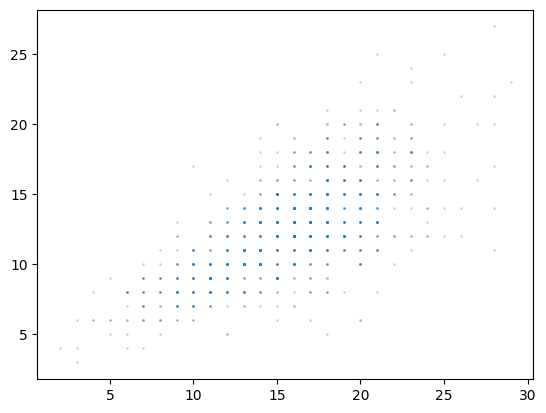

In [106]:
import matplotlib.pyplot as plt
plt.scatter(np.sum(X_train[0:1000], axis = 1), y_train[0:1000], s=1, alpha=0.2)

# Model 

In [79]:
import keras
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GlobalMaxPool1D, GRU, Reshape, Conv1DTranspose, UpSampling1D, Normalization, Dropout
 
def create_model(c1layers=[[32,1,1,'valid',False]], dlayers=[32,32]):
    inputs = Input(shape=(int(num_timepoints/compress_factor),1))
    x = inputs
    # x = Normalization()(x)
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if c[4]:
            x = MaxPooling1D(5)(x)
            npool = npool+1
            

    x = GlobalAveragePooling1D()(x)
    
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)

    # x = Dropout(0.25)(x)

    # x = Conv1D(1, 4, 1, activation = 'linear')(x)

    # outputs = Reshape((1,))(x)
        
    outputs = Dense(1,activation='linear')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="cnn-regressor")
 
 
c1layers=[[16,5,5,'same',False], [16,5,5,'same',False], [16,5,1,'same',False]]
dlayers=[32, 32]
model = create_model(c1layers, dlayers)
 
print(model.summary())

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 100, 16)           96        
                                                                 
 conv1d_28 (Conv1D)          (None, 20, 16)            1296      
                                                                 
 conv1d_29 (Conv1D)          (None, 20, 16)            1296      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                     

In [80]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

loss_fn = tf.keras.losses.MeanSquaredError()
batchSize = 32
nEpochs = 100
learningRate = 1e-2

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.2,
    patience=3,
    min_delta=0.,
    min_lr=1.e-7,
)

# dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(model.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
model.compile(loss=loss_fn, optimizer=opt,
    metrics=tf.keras.metrics.MeanAbsoluteError(name='mae'))

train = True
if train:
    history = model.fit(X_train, y_train, 
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    # model.save('models/norm_cf_4_no_GAP_3conv.keras')
else:
    model = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "cnn-regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 100, 16)           96        
                                                                 
 conv1d_28 (Conv1D)          (None, 20, 16)            1296      
                                                                 
 conv1d_29 (Conv1D)          (None, 20, 16)            1296      
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                     

In [87]:
model.save(model_dir + 'cnn_peak_' + str(T1) + '_' + str(T2) + '.keras')

# Performance Plots

In [ ]:
model = keras.models.load_model(model_dir + 'cnn_peak_0.0759587_0.0435833.keras')

In [88]:
model = keras.models.load_model(model_dir + 'cnn_peak_0.0521_0.0779_0.0779.keras')

In [89]:
model.save(model_dir + 'cnn_peak_0.0521_0.0779.keras')

In [66]:
y_test

array([10., 11., 14., ..., 10., 11., 13.])

In [85]:
preds = model.predict(X_test).flatten()
actual_primaries = y_test

3125/3125 [==============================] - 2s 576us/step


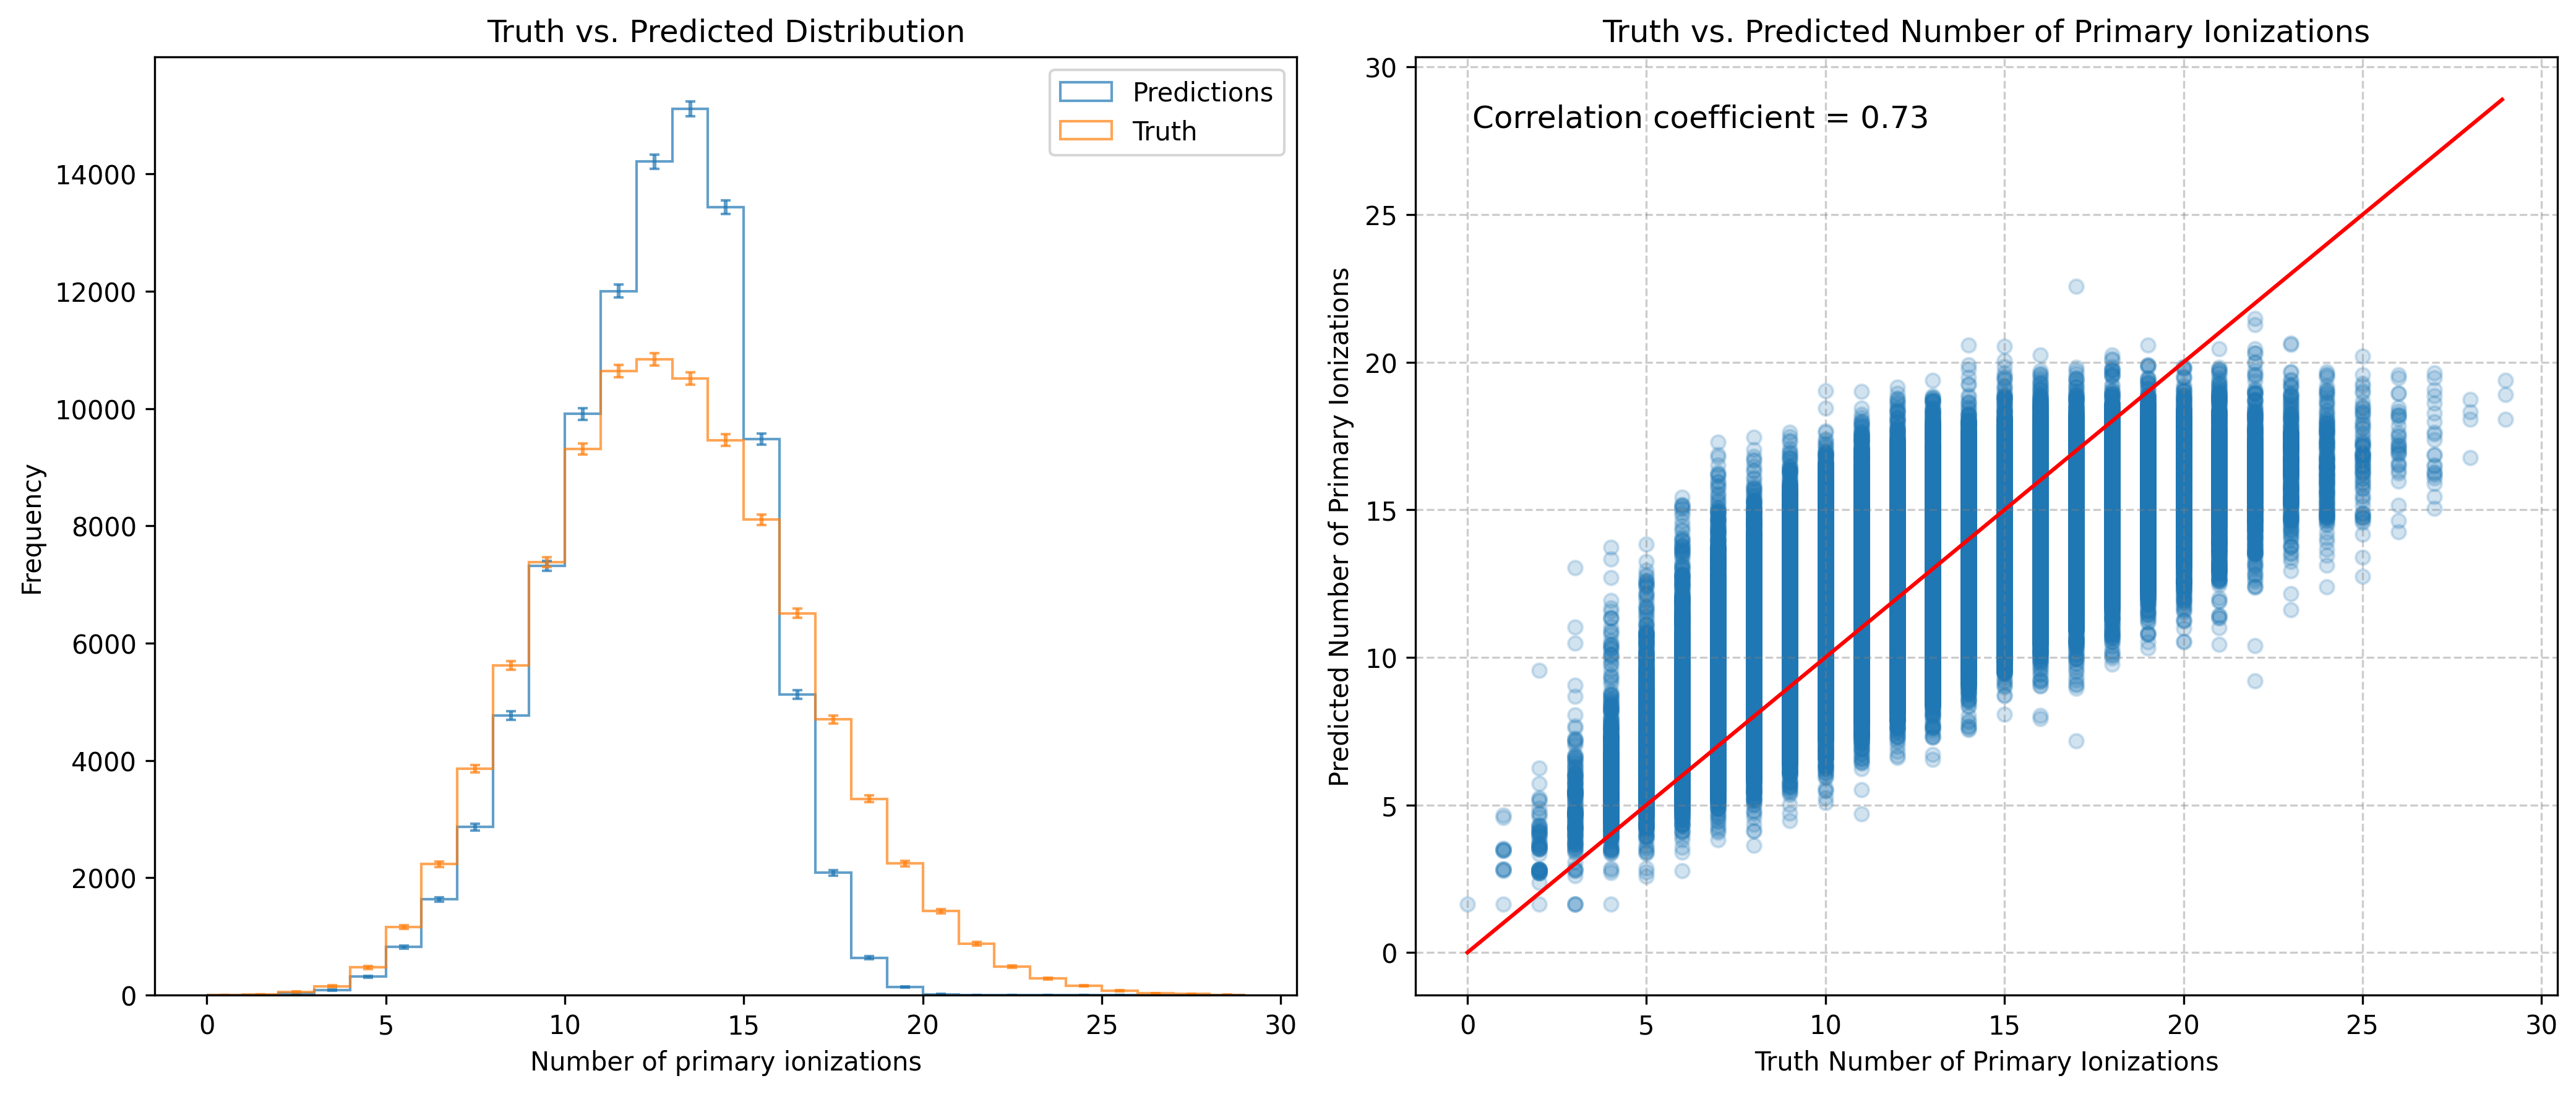

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), dpi=300)

# Left subplot: Histogram comparison
bins = np.arange(30)

# Plot histograms and get counts for error bars
pred_counts, pred_bins, pred_patches = axes[0].hist(preds, bins=bins, histtype='step', label='Predictions', alpha=0.7)
truth_counts, truth_bins, truth_patches = axes[0].hist(np.sum(testdata['tag_values']==1, axis=-1), bins=bins, histtype='step', label='Truth', alpha=0.7)

# Add error bars
bin_centers = (bins[:-1] + bins[1:]) / 2
axes[0].errorbar(bin_centers, pred_counts, yerr=np.sqrt(pred_counts), 
                 fmt='none', capsize=2, color=pred_patches[0].get_edgecolor())
axes[0].errorbar(bin_centers, truth_counts, yerr=np.sqrt(truth_counts), 
                 fmt='none', capsize=2, color=truth_patches[0].get_edgecolor())

axes[0].legend()
axes[0].set_xlabel("Number of primary ionizations")
axes[0].set_ylabel("Frequency")
axes[0].set_title('Truth vs. Predicted Distribution')

# Right subplot: Correlation scatter plot
actual = np.sum(testdata['tag_values']==1, axis=-1)  # Make sure this matches your truth data
predicted = preds
m = 1
b = 0
correlation_coefficient, p_value = pearsonr(actual[:10000], predicted[:10000])
x = np.arange(actual.min(), actual.max(), step=0.1)

axes[1].scatter(actual, predicted, s=30, alpha=0.2)
axes[1].plot(x, m*x + b, color='red')
axes[1].set_xlabel('Truth Number of Primary Ionizations')
axes[1].set_ylabel('Predicted Number of Primary Ionizations')
axes[1].text(0.05, 0.95, f"Correlation coefficient = {correlation_coefficient:.2f}", 
             fontsize=12, color='black', 
             transform=axes[1].transAxes,
             horizontalalignment='left',    
             verticalalignment='top')
axes[1].grid(True, color='gray', linestyle='--', alpha=0.4)
axes[1].set_title('Truth vs. Predicted Number of Primary Ionizations')

plt.tight_layout()
plt.show()
fig.savefig(results_dir + 'model_performance.png')